# Optimización de hiperparámetros de modelos de aprendizaje profundo utilizando Particle Swarm Optimization

## Bibliotecas 

- NumPy
- TensorFlow 
- Keras
- Optunity

Además, se agrega la configuración necesaria para que el experimento sea reproducible. Esta informacion  fue obtenida de la pagina oficial de Keras (https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development). Para que el resultado sea exactamente el mismo en todas las ejecuciones no es posible utilizar paralelismo, esto hace que el tiempo de ejecución aumente considerablemente. Sin embargo, la diferencia entre experimentos al utilizar paralelismo es baja (tercer digito) por lo que se decidió aceptar esta diferencia y reducir los tiempos de computo.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(1234)
import random as rn
rn.seed(12345)
import os
os.environ['PYTHONHASHSEED'] = '0' 
from keras import backend as K

import math
import time
from datetime import timedelta
import optunity
import optunity.metrics
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [50]:
# Funciones adicionales para graficar (blackbox)
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    fig.savefig('plot_images.pdf')

def print_accuracy():   
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    fig.savefig('plot_weights.pdf')

## MNIST Dataset

Se utiliza el conjunto de datos MNIST, el cual contiene 70.000 imagenes de 28x28 pixeles y las etiquetas verdaderas correspondientes. Cada una de las imagenes contiene un número del 0 al 9 escritos a mano, la etiqueta es un vector de 10 elementos con un uno en la ubicación (índice) que se corresponde con el valor representado en la imagen y los demas elementos en cero (codificacion "one-hot").

Este conjunto de datos se divide en tres subconjuntos:

- Entrenamiento
- Test
- Validación

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.array([label.argmax() for label in data.test.labels])
#data.test.cls = np.argmax(data.test.labels, axis=1)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


## <a name="inData"></a> Dimnsiones de los datos 
Se declaran variables que serán utilizadas a lo largo del código y que definen las dimensiones de los datos. Además, se muestran algunas imágenes del set de datos que se esta utilizando.

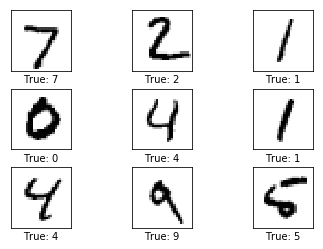

In [49]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size, img_size)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size, img_size, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Number of images per batch
batch_size = 128

# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# TensorFlow

El propósito de TensorFlow es crear grafos computacionales (_computational graph_) que pueden ser ejecutado mas eficientemente que si el cálculo fuera realizado directamente en _Python_. TensorFlow puede ser mas eficiente que NumPy porque conoce el grafo computacional completo, mientras que NumPy únicamente conoce de una operación matemática por vez.

Además, TensorFlow puede calcular autmáticamente los gradientes necesarios para optimizar las variables de los grafos y mejorar la performance del modelo. Esto se debe a que los grafos son una combinación de expresiones matemáticas simples, por lo que el gradiente del grafo se obtiene mediante la _chain rule_ de las derivadas.

Un grafo de TensorFlow consiste de las siguientes partes:

- Variables _placeholder_: usadas para la entrada de datos al grafo.
- Variables del modelo: son aquellas que se modifican durante la optimización del moderlo.
- Modelo: es esencialmente una funcion matemática que calcula una salida a partir de los datos entrada (las variables _placeholder_ y las variables del modelo).
- Funcion de costo: se utiliza para guiar la optimización de las variables.
- Método de optimización: actualiza las variables del modelo.

## Variables _Placeholder_

In [48]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

## Variables a optimizar del modelo

In [7]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

## Modelo

In [8]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Función de pérdida (_loss_) a optimizar

In [9]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Optimización: Gradient Decent

In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.5).minimize(cost)

# Function to control the number of iterations
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

## Sesión de TensorFlow 


Es importante notar que hasta ahora no se realizo ningun cálculo en TensorFlow, únicamente se crearon los objetos de TensorFlow. Para poder ejecutarlo, es necesario primero crear una sesión e inicializar las variables de pesos y sesgos en cero.

In [13]:
session = tf.Session()
session.run(tf.global_variables_initializer())

Se crea la variable $feed\_dict\_test$ la cual es usada como entrada al grafo de _TensorFlow_, se deben utilizar los nombres correctos de los nodos _placeholder_ creados.

In [14]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

### Presición en la clasificación antes de realizar optimizaciones

La presición en el set de test es del 9.8%, esto se debe a que el modelo únicamente fue inicializado pero no optimizado. El 9.8% de las imágenes son el dígito cero, como el modelo se inició en cero, este es el único dígito que clasifica correctamente.

In [15]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print_accuracy()

Accuracy on test-set: 9.8%


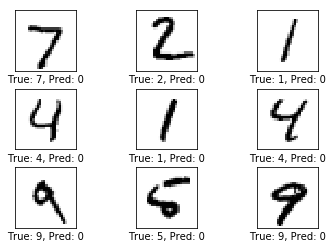

In [16]:
plot_example_errors()

### Presición en la clasificación luego de una iteración de optimización

Luego de una única iteración, el modelo incrementa su presición del 9.8% al 43.5%. Esto significa que clasifica mal 6 imagenes de cada 10, como puede verse a continuación.

Accuracy on test-set: 41.7%


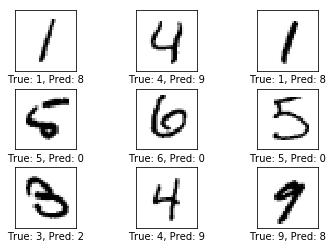

In [17]:
optimize(num_iterations=1)
print_accuracy()
plot_example_errors()

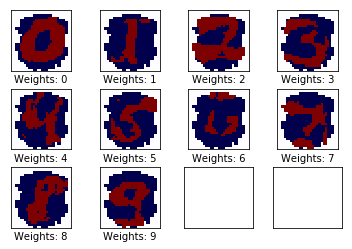

In [18]:
plot_weights()

### Presición en la clasificación luego de 1000 iteraciones de optimización

Luego de 1000 iteraciones, el modelo clasifica mal una de cada diez imágenes aproximadamente. Como se demuestra a continuación, alguna de las clasificaciones erroneas están justificadas, ya que, es muy difícil diferenciar incluso para las personas, mientras que otras son bastante obvias y deberían haber sido clasificadas correctamente. Sin embargo, este modelo simple no puede comportarse mucho mejor, es necesario un modelo más complejo.

Accuracy on test-set: 89.4%


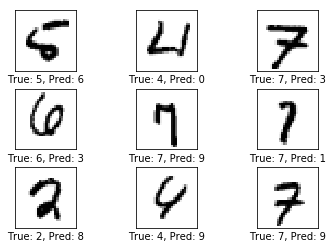

In [19]:
# We have already performed 10 iterations.
optimize(num_iterations=990)
print_accuracy()
plot_example_errors()

El modelo ahora fue entrenado con 1000 iteraciones de optimización, cada iteración usando 100 imagenes del set de entrenamiento. Debido a la gran variedad de imágenes, los pesos ahora se volvieron muy difícil de interprtar y podriamos preguntarnos si el modelo realmente entendió como los digitos se componen de lineas o si simplemente el modelo memorizó diferentes variaciones de pixeles.

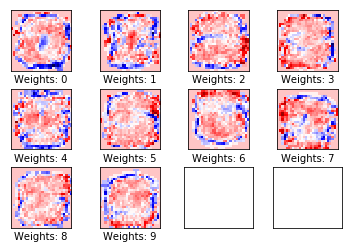

In [20]:
plot_weights()

A continuación se grafica la matriz de confusión que nos permite analizar en detalle las clasificaciones erroneas. Por ejemplo, nos muestra que las imágenes con el digito 5, a veces son confundidas con digitos como el 3, 8, o 9.

[[ 947    0    1    2    0    5   15    2    4    4]
 [   0 1122    2    4    0    1    3    2    1    0]
 [   3   32  839   30    8    6   17    8   79   10]
 [   5    0   13  912    5   18    5    7   31   14]
 [   3    3    6    1  818    1   17    6   12  115]
 [  14    3    0   47   11  715   23    3   60   16]
 [   8    3    5    2    5    7  922    2    4    0]
 [   1   12   15   18    7    1    0  901    2   71]
 [  11   30    3   26    8   25    8    5  829   29]
 [   5    9    0   12   15    5    1   10   15  937]]


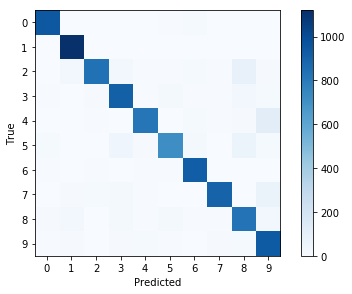

In [21]:
print_confusion_matrix()

Finalmente se cierra la sesión de _TensorFlow_ y se liberan los recursos.



In [22]:
session.close()

## Deep Neural Network con Keras

A continuación, se crea una función para crear la estructura de la red neuronal a partir de los hiperparámetros:
- $num\_dense\_layers$: número de capas de la red.
- $activation$: método de activación de las neuronas, puede ser ReLU o Sigmoid.
- $learning\_rate$:  _learning rate_ del optimizador Adam.
- $num\_dense\_nodes$: número de neuronas en cada capa.

La API _keras_ tiene dos modos de construcción de redes neuronales, el mas simple es el llamado _Sequential Model_ donde las capas se van agregando en forma secuencial. Como el número de capas es un hiperparámetro, se utiliza un bucle _for_ para agregar las capas secuencialmente.

Una vez definida la arquitectura della red neuronal, es necesario agregar la función de pérdida, el optimizados y la métrica de medicion de _performance_. Esto se hace mediante la compilación del modelo. Como se estableció anteriormente, se elige como optimizador el algoritmo _Adam_, como funcón de pérdida $categorical\_crossentropy$ y como métrica de _performance_ la presición de clasificación.

In [71]:
## Create the neural network with these hyper-parameters
def create_model (num_dense_layers, activation,
                 learning_rate, num_dense_nodes):
    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(int(num_dense_layers)):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(int(num_dense_nodes[i]),
                        activation=activation,
                        name=name))
        if(activation == 'linear'):
            model.add(LeakyReLU(alpha=.001))   # add an advanced activation
            
    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return(model)

## Optimización de hiperparámetros

### Espacio de búsqueda
 
 Los hiperparámetros a optimizar son:
 
- $num\_dense\_layers$: número de capas de la red.
- $activation$: método de activación de las neuronas, puede ser ReLU o Sigmoid.
- $learning\_rate$: _learning rate_ del optimizador Adam.
- $num\_dense\_nodes$: número de neuronas en cada capa.

A continuación se define el espacio de búsqueda definiendo los límites y una función que verifica que la partícula se encuentre dentro de ellos.

In [72]:
## Optunity PSO optimization search space
# Activation 
activation_cat = ['relu', 'sigmoid', 'tanh', 'linear']
# Maximum and minimum number of nodes or neurons
max_dense_nodes = 128 
min_dense_nodes = 10
# Maximum and minimum learning rate for the optimizer
max_learning_rate = 1e-2
min_learning_rate = 1e-6

search = {'DNN': {'1_layer': {'layer1_lr': [min_learning_rate, max_learning_rate],
                              'layer1_nodes_l1': [min_dense_nodes, max_dense_nodes],
                              'layer1_act': [0,3]},
                  '2_layer': {'layer2_lr': [min_learning_rate, max_learning_rate],
                              'layer2_nodes_l1': [min_dense_nodes, max_dense_nodes],
                              'layer2_nodes_l2': [min_dense_nodes, max_dense_nodes],
                              'layer2_act': [0,3]},
                  '3_layer': {'layer3_lr': [min_learning_rate, max_learning_rate],
                              'layer3_nodes_l1': [min_dense_nodes, max_dense_nodes],
                              'layer3_nodes_l2': [min_dense_nodes, max_dense_nodes],
                              'layer3_nodes_l3': [min_dense_nodes, max_dense_nodes],
                              'layer3_act': [0,3]}
                  }
           }

La siguientes funciones se utilizan para calcular el valor _fitness_ de cada partícula, en este caso, el _fitness_ es la presición con que se logró clasificar el set de validación. Evaluar la precisión con que se clasifica, implica crear el modelo con los hiperparámetros que la partícula establece, entrenar el modelo y luego evaluarlo.
La creación del modelo se realiza llamando a la función $create\_model$ descripta anteriormente. Una vez que el model fue definido completamente con función de pérdida y optimizador, es necesario entrenarlo. Esta función toma dos _numpy-arrays_ y realiza tantos entrenamientos como se especifiquen en el argumento $epochs$ y utilizando el tamaño de _batch_ especificado.

Finalmente, es momento obtener la métrica de calidad de clasificación (_accuracy_), esto se hace mediante la evaluación del modelo entrenado. Para esto no se puede utilizar el conjunto de _test_, por que se obtendria un set de parámetros especificamente para este set de datos causando _overfitting_. Por esto se utiliza la técnica de _k-fold cross-validation_ donde el conjunto de entrenamiento se divide en $k$ pliegues, y luego se itera realizando $k$ entrenamientos y utilizando un pligue como validaciòn distinto en cada uno de ellos. Se obtenienen 5 resultados que luego se promedian para obtener el valor final de _fitness_.

In [73]:
## Calculate the fitness value
def calculate_fitness (num_dense_layers, activation,
                       learning_rate, num_dense_nodes):
    # number of folds
    k = 5 
    # calculate the fold size
    n_samples = len(data.train.images)
    fold_size = n_samples // k
    # Create list for saving the scores 
    scores = []
    masks = []
    for fold in range(k):
        # Creation of the tensorFlow model with the PSO particle parameters
        model = create_model(num_dense_layers, activation, learning_rate, num_dense_nodes)
        if fold == 0:
            print(activation)
            print(model.summary())
        # generate a boolean mask for the test set in this fold
        test_mask = np.zeros(n_samples, dtype=bool)
        test_mask[fold * fold_size : (fold + 1) * fold_size] = True
        # store the mask for visualization
        masks.append(test_mask)
        # create training and test sets using this mask
        X_test, y_test = data.train.images[test_mask], data.train.labels[test_mask]
        X_train, y_train = data.train.images[~test_mask], data.train.labels[~test_mask]
        # fit the classifier
        ## Training
        model.fit(x=X_train,
                  y=y_train,
                  epochs=3,
                  batch_size=batch_size,
                  verbose=0)
        ## Evaluation
        result = model.evaluate(x=X_test,
                                y=y_test,
                                verbose=0)
        # compute the score and record it
        scores.append(result[1])
       
        print("Fold: " + str(fold))        
        print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
        # Delete the Keras model with these hyper-parameters from memory. 
        del model
        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        session.close()
    print(np.abs(np.mean(scores)))
    return (np.abs(np.mean(scores)))

### 0 capas ocultas = Clasificador Lineal

In [65]:
num_dense_layers = 0
num_dense_nodes = [0,0,0,0,0]
learning_rate=(min_learning_rate + max_learning_rate)/2
print(learning_rate)
calculate_fitness(num_dense_layers,activation_cat[0],learning_rate, num_dense_nodes)

0.0050005
relu
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
Fold: 0
acc: 91.77% loss 0.279128506704
Fold: 1
acc: 91.58% loss 0.295163570957
Fold: 2
acc: 92.16% loss 0.292704672207
Fold: 3
acc: 91.95% loss 0.290480927034
Fold: 4
acc: 91.25% loss 0.302580276262
0.91741818181


0.91741818180951218

 ### Optunity
 
 Optunity es una biblioteca que contiene varios optimizadores de hiperparámetros, incluyendo __PSO__. En el siguiente código, se inicializa el _solver_ con los siguientes hiperparametros del _particle swarm_:

- num_particles (int): Número de partículas
- num_generations (int): Máximo número de generaciones
- max_speed (float or None): Velocidad máxima de cada partícula
- phi1 (float): Coeficiente de aceleración que determina la influencia relativa del _local best_
- phi2 (float): Coeficiente de aceleración que determina la influencia relativa del _global best_
- kwargs ({'name': [lb, ub], ..}): Dimensiones del espacio de busqueda y sus respectivos valores máximos y mínimos

### 0 capas ocultas = Clasificador Lineal

### 1 capa oculta

In [84]:
start_time = time.time()
f = create_objective_function()
omega = 1.0/(2.0*np.log(2))
phi = 0.5 + np.log(2)

num_dense_layers = 1

def create_objective_function():
    def f(activation,
          learning_rate, 
          dense_layer0):

        num_dense_nodes = [dense_layer0,0,0,0,0]
        if (activation > 3):
            activation = 3
        fitness = 1.0/calculate_fitness(num_dense_layers,activation_cat[round(activation)],learning_rate, num_dense_nodes)
        return fitness
    return f

pso = optunity.solvers.ParticleSwarm(num_particles=5,
                                     num_generations=5,
                                     max_speed=omega, 
                                     phi1=phi,phi2=phi,
                                     activation=[0, 3], 
                                     learning_rate=[min_learning_rate, max_learning_rate], 
                                     dense_layer0=[1, max_dense_nodes])
pars,details = pso.minimize(f)
print(pars)
num_dense_nodes_res = [int(pars['dense_layer0']),0,0,0,0]

end_time = time.time()
time_dif = end_time - start_time

linear
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 33)                25905     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 33)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                340       
Total params: 26,245
Trainable params: 26,245
Non-trainable params: 0
_________________________________________________________________
None
Fold: 0
acc: 94.89% loss 0.174245655911
Fold: 1
acc: 94.50% loss 0.184360369569
Fold: 2
acc: 95.15% loss 0.17826475791
Fold: 3
acc: 94.68% loss 0.18694214664
Fold: 4
acc: 94.54% loss 0.184599677709
0.947527272719
sigmoid
_____________________________________

In [85]:
print("Time: " + str(time_dif))

model = create_model(num_dense_layers, 
                     activation_cat[round(pars['activation'])], 
                     pars['learning_rate'], 
                     num_dense_nodes_res)

print("Activation function: " + str(activation_cat[round(pars['activation'])]))
print(model.summary())
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=3,
          batch_size=batch_size,
          verbose=0)
## Evaluation
result = model.evaluate(x=data.test.images,
                        y=data.test.labels,
                        verbose=0)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
# Delete the Keras model with these hyper-parameters from memory. 
del model
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

Time: 781.0128231048584
Activation function: linear
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 143)               112255    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 143)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1440      
Total params: 113,695
Trainable params: 113,695
Non-trainable params: 0
_________________________________________________________________
None
acc: 97.31% loss 0.0855314503635


## 2 capas Ocultas

In [74]:
start_time = time.time()
f = create_objective_function()
omega = 1.0/(2.0*np.log(2))
phi = 0.5 + np.log(2)

num_dense_layers = 2

def create_objective_function():
    def f(activation,
          learning_rate, 
          dense_layer0,
          dense_layer1):

        print(activation, learning_rate, dense_layer0,dense_layer1)
        
        if (activation > 3):
            activation = 3
        if (activation < 0):
            activation = 0
        if (learning_rate < min_learning_rate):
            learning_rate = min_learning_rate
        if (learning_rate > max_learning_rate):
            learning_rate = max_learning_rate
        if (dense_layer0 < min_dense_nodes):
            dense_layer0 = min_dense_nodes
        if (dense_layer1 < min_dense_nodes):
            dense_layer1 = min_dense_nodes

        num_dense_nodes = [dense_layer0,dense_layer1,0,0,0]            
            
        fitness = 1.0/calculate_fitness(num_dense_layers,activation_cat[round(activation)],learning_rate, num_dense_nodes)
        return fitness
    return f

pso = optunity.solvers.ParticleSwarm(num_particles=5,
                                     num_generations=5,
                                     max_speed=omega, 
                                     phi1=phi,phi2=phi,
                                     activation=[0, 3], 
                                     learning_rate=[min_learning_rate, max_learning_rate], 
                                     dense_layer0=[1, max_dense_nodes],
                                     dense_layer1=[1, max_dense_nodes])
pars,details = pso.minimize(f)
print(pars)
num_dense_nodes_res = [int(pars['dense_layer0']),int(pars['dense_layer1']),0,0,0]

end_time = time.time()
time_dif = end_time - start_time

1.83544921875 0.0007870541992187501 18.05322265625 98.91650390625
tanh
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 18)                14130     
_________________________________________________________________
layer_dense_2 (Dense)        (None, 98)                1862      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                990       
Total params: 16,982
Trainable params: 16,982
Non-trainable params: 0
_________________________________________________________________
None
Fold: 0
acc: 93.68% loss 0.213752129425
Fold: 1
acc: 93.46% loss 0.216321068341
Fold: 2
acc: 93.65% loss 0.220552415328
Fold: 3
acc: 93.42% loss 0.224116514461
Fold: 4
acc: 93.09% loss 0.2268745

In [75]:
print("Time: " + str(time_dif))

model = create_model(num_dense_layers, 
                     activation_cat[round(pars['activation'])], 
                     pars['learning_rate'], 
                     num_dense_nodes_res)

print("Activation function: " + str(activation_cat[round(pars['activation'])]))
print(model.summary())
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=3,
          batch_size=batch_size,
          verbose=0)
## Evaluation
result = model.evaluate(x=data.test.images,
                        y=data.test.labels,
                        verbose=0)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
# Delete the Keras model with these hyper-parameters from memory. 
del model
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

Time: 687.4098429679871
Activation function: linear
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
layer_dense_1 (Dense)        (None, 177)               138945    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 177)               0         
_________________________________________________________________
layer_dense_2 (Dense)        (None, 44)                7832      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 44)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                450       
Total params: 147,227
Trainable params: 147,227
Non-trainable params: 0
__________________

In [66]:
## Create the neural network with these hyper-parameters
def create_model (activation, learning_rate, nodes_fcl_3,
                  filterSize1, filterSize2,
                  numFilter1, numFilter2):
    # Start construction of the Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    model.add(Reshape(img_shape_full))

    # First convolutional layer with ReLU-activation and max-pooling.
    model.add(Conv2D(kernel_size=filterSize1, strides=1, filters=numFilter1, padding='same',
                     activation=activation, name='layer_conv1'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer with ReLU-activation and max-pooling.
    model.add(Conv2D(kernel_size=filterSize2, strides=1, filters=numFilter2, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # First fully-connected / dense layer with ReLU-activation.
    model.add(Dense(nodes_fcl_3, activation='relu'))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return(model)

## Calculate the fitness value
def calculate_fitness (activation, learning_rate, nodes_fcl_3,
                       filterSize1, filterSize2,
                       numFilter1, numFilter2):
    # number of folds
    k = 5 
    # calculate the fold size
    n_samples = len(data.train.images)
    fold_size = n_samples // k
    # Create list for saving the scores 
    scores = []
    masks = []
    for fold in range(k):
        # Creation of the tensorFlow model with the PSO particle parameters
        model = create_model(activation, learning_rate, nodes_fcl_3,
                             filterSize1, filterSize2,
                             numFilter1, numFilter2)
        if fold == 0:
            print(activation)
            print(model.summary())
        # generate a boolean mask for the test set in this fold
        test_mask = np.zeros(n_samples, dtype=bool)
        test_mask[fold * fold_size : (fold + 1) * fold_size] = True
        # store the mask for visualization
        masks.append(test_mask)
        # create training and test sets using this mask
        X_test, y_test = data.train.images[test_mask], data.train.labels[test_mask]
        X_train, y_train = data.train.images[~test_mask], data.train.labels[~test_mask]
        # fit the classifier
        ## Training
        model.fit(x=X_train,
                  y=y_train,
                  epochs=3,
                  batch_size=batch_size,
                  verbose=0)
        ## Evaluation
        result = model.evaluate(x=X_test,
                                y=y_test,
                                verbose=0)
        # compute the score and record it
        scores.append(result[1])
       
        print("Fold: " + str(fold))        
        print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
        # Delete the Keras model with these hyper-parameters from memory. 
        del model
        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()
        session.close()
    print(np.abs(np.mean(scores)))
    return (np.abs(np.mean(scores)))

start_time = time.time()
f = create_objective_function()
omega = 1.0/(2.0*np.log(2))
phi = 0.5 + np.log(2)

num_dense_layers = 1

def create_objective_function():
    def f(activation, learning_rate, nodes_fcl_3,
          filterSize1, filterSize2,
          numFilter1, numFilter2):

        if (activation > 3):
            activation = 3
        if (nodes_fcl_3 < 1):
            nodes_fcl_3 = 1
        if (filterSize1 < 1):
            filterSize1 = 1
        if (filterSize2 < 1):
            filterSize2 = 1
        if (numFilter1 < 1):
            numFilter1 = 1
        if (numFilter2 < 1):
            numFilter2 = 1  
        if (learning_rate < min_learning_rate ):
            learning_rate = min_learning_rate
        fitness = 1.0/calculate_fitness(activation_cat[round(activation)],
                                        learning_rate, int(nodes_fcl_3),
                                        int(filterSize1), int(filterSize2),
                                        int(numFilter1), int(numFilter2))
        return fitness
    return f

pso = optunity.solvers.ParticleSwarm(num_particles=5,
                                     num_generations=5,
                                     max_speed=omega, 
                                     phi1=phi,phi2=phi,
                                     activation=[0, 3], 
                                     learning_rate=[min_learning_rate, max_learning_rate], 
                                     nodes_fcl_3=[1, max_dense_nodes],
                                     filterSize1 = [1, 6], 
                                     filterSize2 = [1, 6],
                                     numFilter1  = [1, 64], 
                                     numFilter2  = [1, 64])
pars,details = pso.minimize(f)
print(pars)


end_time = time.time()
time_dif = end_time - start_time

sigmoid
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 48)        816       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 48)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 50)        21650     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2450)              0         
__

In [69]:
print("Time: " + str(time_dif))


model = create_model(activation_cat[round(pars['activation'])], pars['learning_rate'], 
                    int(pars['nodes_fcl_3']),
                    int(pars['filterSize1']), int(pars['filterSize2']),
                    int(pars['numFilter1']), int(pars['numFilter2']))
    
print("Activation function: " + str(activation_cat[round(pars['activation'])]))
print(model.summary())
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=3,
          batch_size=batch_size,
          verbose=0)
## Evaluation
result = model.evaluate(x=data.test.images,
                        y=data.test.labels,
                        verbose=0)

print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]),model.metrics_names[0],result[0])
# Delete the Keras model with these hyper-parameters from memory. 
del model
# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

Time: 8814.0912733078
Activation function: relu
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 9)         153       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 9)         0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 58)        8410      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 58)          0         
_________________________________________________________________
flatten_1 (Flatten)         

## Resultados

| Topologiía | Accuracy | Lost | Parámetros |     Time    |
|------------|----------|------|------------|-------------|
|    CL      |  91.25%  |0.3025|   7,850    |      -      |
|    RN 2    |  97.31%  |0.0855|  113,695   |   13 min    |
|    RN 3    |  97.05%  |0.1064|  147,227   |   11 min    |
|    RNC     |  98.62%  |0.0435|  228,254   | 2 hrs 45 min|

- CL: Clasificador linal
- RN 2: Red Neuronal con una capa oculta
- RN 3: Red Neuronal con dos capas ocultas
- RNC: Red Neuronal Convolucional